In [1]:
!git clone https://github.com/BenBasilTomy/data

Cloning into 'data'...
remote: Enumerating objects: 26219, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 26219 (delta 0), reused 2 (delta 0), pack-reused 26214
Receiving objects: 100% (26219/26219), 581.45 MiB | 16.49 MiB/s, done.
Checking out files: 100% (11729/11729), done.


In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time

In [13]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = '/content/data/train'  
validation_data_dir = '/content/data/val'  
test_data_dir = '/content/data/test'
   
# number of epochs to train top model  
epochs = 15

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [4]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [6]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 7035 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


Time:  0:00:54.062383


In [7]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2344 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


Time:  0:00:17.225684


In [8]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2350 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Time:  0:00:14.314298


In [9]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 7035 images belonging to 6 classes.


In [10]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2344 images belonging to 6 classes.


In [11]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 2350 images belonging to 6 classes.


In [14]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7
141/141 [==============================] - 3s 14ms/step - loss: 1.1068 - acc: 0.5889 - val_loss: 0.6336 - val_acc: 0.7892
Epoch 2/7
141/141 [==============================] - 1s 7ms/step - loss: 0.6604 - acc: 0.7663 - val_loss: 0.5091 - val_acc: 0.8272
Epoch 3/7
141/141 [==============================] - 1s 8ms/step - loss: 0.5235 - acc: 0.8134 - val_loss: 0.4248 - val_acc: 0.8511
Epoch 4/7
141/141 [==============================] - 1s 7ms/step - loss: 0.4324 - acc: 0.8466 - val_loss: 0.4379 - val_acc: 0.8541
Epoch 5/7
141/141 [==============================] - 1s 7ms/step - loss: 0.3799 - acc: 0.8702 - val_loss: 0.3646 - val_acc: 0.8660
Epoch 6/7
141/141 [==============================] - 1s 8ms/step - loss: 0.3293 - acc: 0.8880 - val_loss: 0.3851 - val_acc: 0.8622
Epoch 7/7
47/47 [==============================] - 0s 4ms/step - loss: 0.3621 - acc: 0.8780
[INFO] accuracy: 87.80%
[INFO] Loss: 0.36210641264915466
Time:  0:00:09.777686


In [15]:


#Model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               2508900   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 306       
                                                                 
Total params: 2,514,256
Trainable params: 2,514,256
No

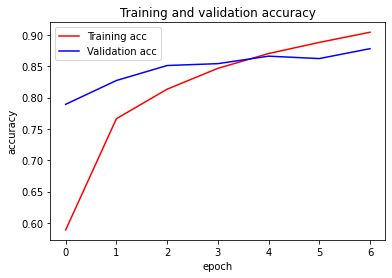

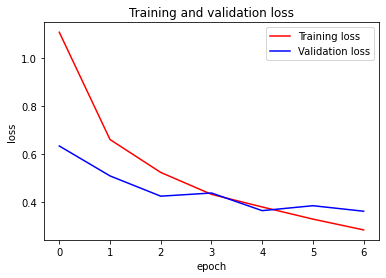

In [16]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()



In [17]:
model.evaluate(test_data, test_labels)

74/74 [==============================] - 0s 4ms/step - loss: 0.3523 - acc: 0.8774


[0.35231685638427734, 0.8774468302726746]

In [19]:
animals = ['butterfly', 'cow', 'elephant', 'horse', 'sheep', 'squirell']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

NameError: ignored

In [20]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [82]:
def test_single_image(path):
    animals = ['butterfly', 'cow', 'elephant', 'horse', 'sheep', 'squirell']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)

    print(animals)
    correct_index = np.argmax(preds[0])
    return animals[correct_index]
    
    
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = np.argmax(bt_prediction,axis=1)
    class_dictionary = generator_top.class_indices  
    
    inv_map = {v: k for k, v in class_dictionary.items()}  
  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [86]:
#path of image that is used for testing
# path = '/content/data/test/horse/OIP--RiUPOTBjthmPdFJET-JHQHaJ4.jpeg'
# path = '/content/data/test/elephant/OIP-0T-7UOb4iXQMEhwTzCXi6gAAAA.jpeg'
path = '/content/data/test/sheep/OIP--S44hiu6-CBwY5MH11WF-QHaEK.jpeg'


In [87]:
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 13ms/step
['butterfly', 'cow', 'elephant', 'horse', 'sheep', 'squirell']


'sheep'